## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

# modify to where you store your project data including utils.py

#datadir = "/content/drive/My Drive/cs445_projects/proj3/" 
datadir = "/Users/djbautista/anaconda3/envs/cs445_env/cs445_proj3_starter_codee" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: /Users/djbautista/anaconda3/envs/cs445_env/cs445_proj3_starter_codeeutils.py: No such file or directory
cp: /Users/djbautista/anaconda3/envs/cs445_env/cs445_proj3_starter_codeesamples: No such file or directory


## Part 1 Toy Problem (20 pts)

In [7]:
def toy_reconstruct(img):
    
    im_h, im_w = img.shape

    neq = im_h*(im_w-1) + (im_h-1)*im_w + 1
    A = scipy.sparse.lil_matrix((neq, im_h*im_w))
    b = np.zeros((neq,1), dtype='double')
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w) 

    e = -1
    for y in range(im_h):
        for x in range(im_w-1):
            e += 1
            A[e, im2var[y, x+1]] = 1 
            A[e, im2var[y, x]] = -1 
            b[e] = img[y, x+1] - img[y, x]
    
    for y in range(im_h-1):
        for x in range(im_w):
            e += 1
            A[e, im2var[y+1, x]] = 1 
            A[e, im2var[y, x]] = -1 
            b[e] = img[y+1, x] - img[y, x]
    A[e, im2var[0, 0]] = 1 
    b[e] = img[0, 0]
    A = A.tocsr()
    v = scipy.sparse.linalg.lsqr(A, b, atol=1e-14, btol=1e-14)[0]
    return v.reshape((im_h, im_w))

    #v = scipy.sparse.linalg.lsqr(A.tocsr(), b); # solve w/ csr

    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    
    # TO DO


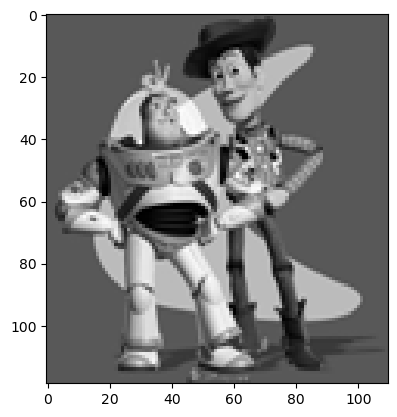

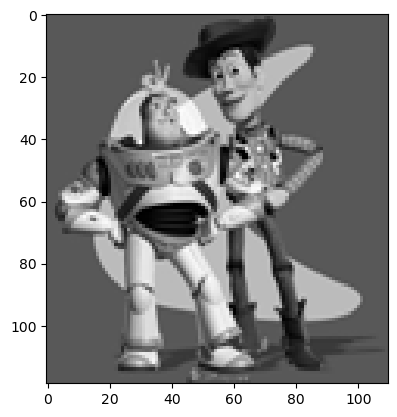

Max error is:  6.081080083930601e-12


In [8]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

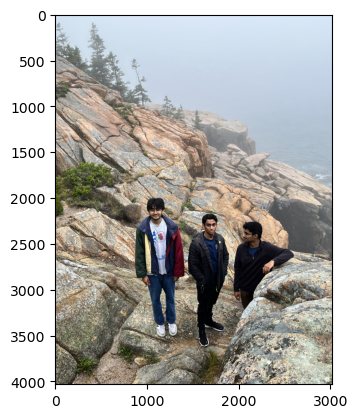

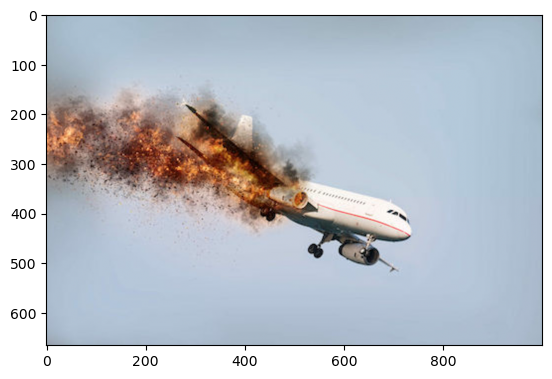

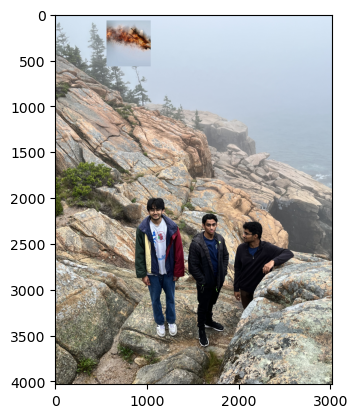

In [95]:
background_img = cv2.cvtColor(cv2.imread('samples/Cliff.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/plane.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  ys = (100, 600, 600, 100)
  xs = (20, 20, 80 500)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (800, 570) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



In [24]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = specify_mask(object_img)

In [11]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = get_mask(ys, xs, object_img)

In [12]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = specify_bottom_center(background_img)
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



## Part 2 Poisson Blending (50 pts)

In [86]:
def column_iter(offset1, offset2,val,im2var, width, height):
    col_in = np.append(
        np.array([[im2var[y][x] if object_mask[y][x]==1 else im2var[y+offset1][x+offset2] for x in range(width)]for y in range(height) if y!=val]).flatten(), 
        np.array([[im2var[y+offset1][x+offset2] for x in range(width)] for y in range(height) if y!=val]).flatten()
    )
    return col_in
def column_iter2(offset1, offset2, val, im2var, width, height):
    col_in = np.append(
        np.array([[im2var[y][x] if object_mask[y][x]==1 else im2var[y+offset1][x+offset2] for y in range(height)]for x in range(width) if x!=val]).flatten(),
        np.array([[im2var[y+offset1][x+offset2] for y in range(height)]for x in range(width) if x!=val]).flatten()
    )
    return col_in
def data_iter(val, height, width):
    first = np.ones(height*width - width), 
    return np.append(first, 
                        np.array([[-1 if object_mask[y][x]==1 else 0 for x in range(width)] for y in range(height) if y!=val]).flatten())
def data_iter2(val, height, width):
    first = np.ones(height*width - height), 
    return np.append(first, 
                    np.array([[-1 if object_mask[y][x]==1 else 0 for y in range(height)]for x in range(width) if x!=val]).flatten() )



def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    
    height, width = object_img.shape
    im2var = np.arange(height * width).reshape(height, width)
    y_shift, x_shift = bg_ul

    def directional_append(offset1, offset2, val):
        b_in = np.array([[object_img[y][x] - object_img[y+offset1][x+offset2] if object_mask[y][x]==1 else bg_img[y+y_shift][x+x_shift] for x in range(width)] for y in range(height) if y!=val])
        return b_in.flatten()
    
    def directional_append2(offset1, offset2, val):
        b_in = np.array([[object_img[y][x]-object_img[y+offset1][x+offset2] if object_mask[y][x]==1 else bg_img[y+y_shift][x+x_shift] for y in range(height)]for x in range(width) if x!=val])
        return b_in.flatten()

    b_top = directional_append(1, 0, height-1)
    row_top = np.append(np.arange(height*width - width), np.arange(height*width - width))
    col_top = column_iter(1, 0, height-1, im2var, width, height)
    data_top = data_iter(height-1, height, width)

    
    b_bottom = directional_append(-1, 0, 0)
    row_bottom = np.append(np.arange(height*width - width, 2*(height*width - width)), np.arange(height*width - width, 2*(height*width - width)))
    col_bottom = column_iter(-1, 0, 0, im2var, width, height)
    data_bottom = data_iter(0, height, width)

    b_right = directional_append2(0, 1, width-1)
    row_right = np.append(np.arange(2*(height*width - width), 3*(height*width)-2*width - height), np.arange(2*(height*width - width), 3*(height*width)-2*width - height))
    col_right = column_iter2(0, 1, width-1, im2var, width, height)
    data_right = data_iter2(width-1, height, width)
    
    b_left = directional_append2(0, -1, 0)
    row_left = np.append(np.arange(3*(height*width)-2*width - height, 4*(height*width)-2*width - 2*height), np.arange(3*(height*width)-2*width - height, 4*(height*width)-2*width - 2*height))
    col_left = column_iter2(0, -1, 0, im2var, width, height)
    data_left = data_iter2(0, height, width)

    rows = np.concatenate((row_top, row_bottom, row_right, row_left))
    cols = np.concatenate((col_top, col_bottom, col_right, col_left))
    
    data = np.concatenate((data_top, data_bottom, data_right, data_left))
    A = scipy.sparse.coo_matrix((data, (rows, cols)), shape=(4*(height*width)-2*height-2*width, height*width))
    b = np.array([ np.concatenate((b_top, b_bottom, b_right, b_left))]).T
    blended_img, _, _, _ = scipy.sparse.linalg.lsqr(A, b)[:4]
    
    
    blended_img = blended_img.reshape(height, width)
    return blended_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


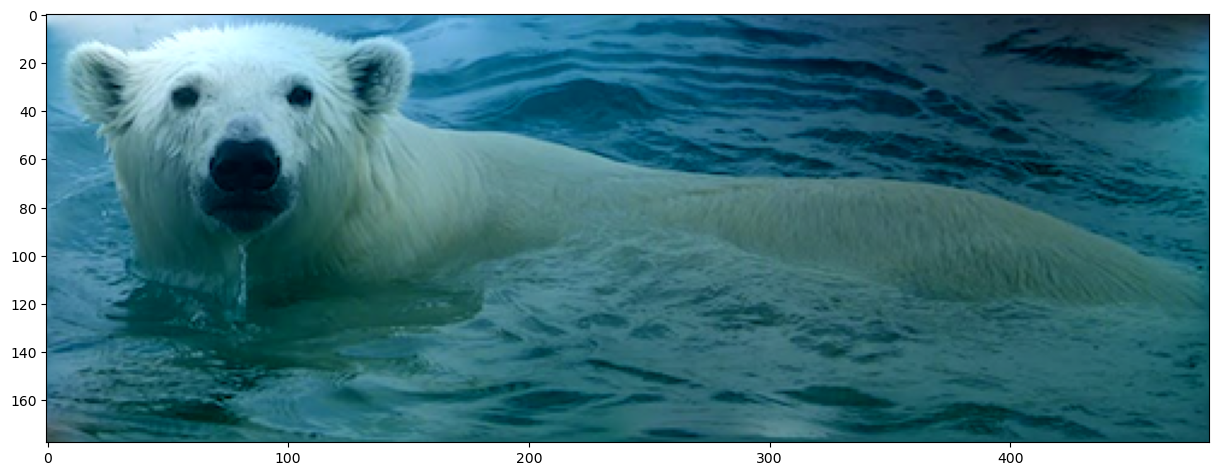

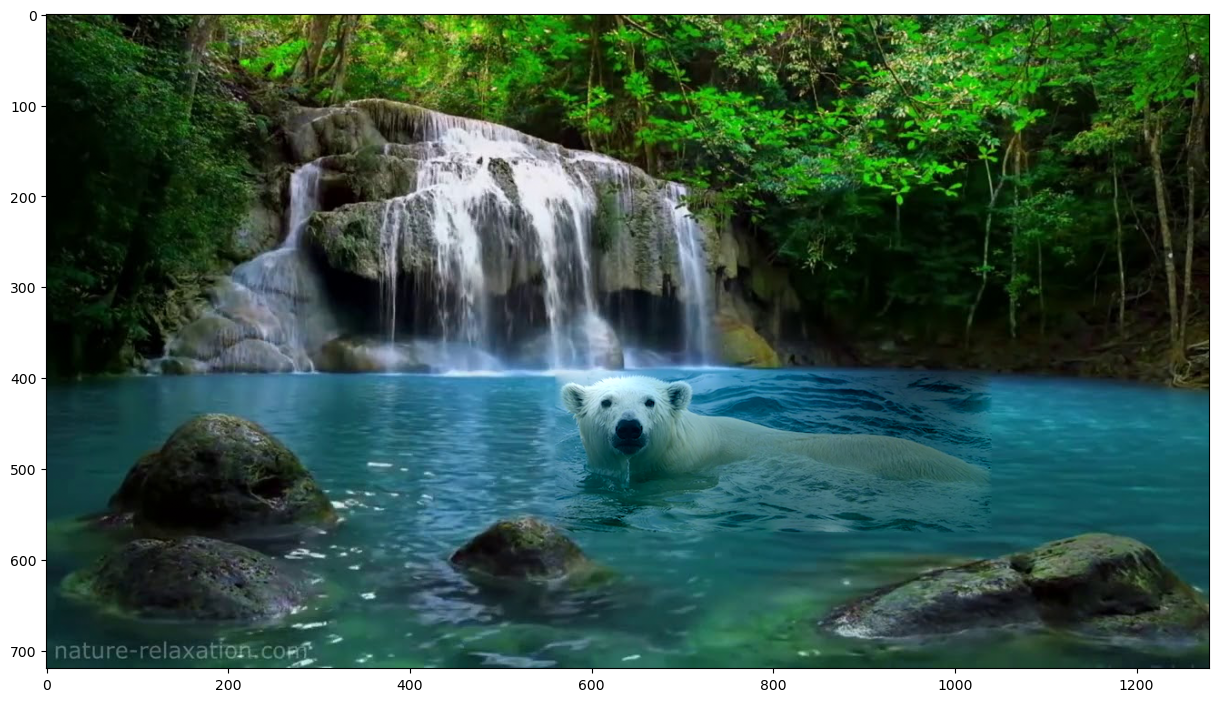

In [87]:
im_blend = np.zeros(object_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)
plt.savefig('results/test')


combined_img = utils.get_combined_img(background_img, im_blend, object_mask, bg_ul)
plt.figure(figsize=(15,15))
plt.imshow(combined_img)
plt.savefig('results/test2')


## Part 3 Mixed Gradients (20 pts)

In [88]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    height, width = object_img.shape
    im2var = np.arange(height * width).reshape(height, width)
    y_shift, x_shift = bg_ul
    
    def directional_append(offset1, offset2, val):
        b_in = np.array([[max([object_img[y][x]-object_img[y+offset1][x], bg_img[y+y_shift][x+x_shift]-bg_img[y+y_shift+offset2][x+x_shift]], key=abs) if object_mask[y][x]==1 else bg_img[y+y_shift][x+x_shift] for x in range(width)] for y in range(height) if y!=val])
        return b_in.flatten()
    
    def directional_append2(offset1, offset2, val):
        b_in = np.array([[max([object_img[y][x]-object_img[y][x+offset1], bg_img[y+y_shift][x+x_shift]-bg_img[y+y_shift][x+x_shift+offset2]], key=abs) if object_mask[y][x]==1 else bg_img[y+y_shift][x+x_shift] for y in range(height)]for x in range(width) if x!=val])
        return b_in.flatten()

    b_top = directional_append(1,1,height-1)
    row_top = np.append(np.arange(height*width - width), np.arange(height*width - width))
    col_top = column_iter(1, 0, height-1, im2var, width, height)
    data_top = data_iter(height-1, height, width)
    
    b_bottom = directional_append(-1, -1, 0)
    row_bottom = np.append(np.arange(height*width - width, 2*(height*width - width)), np.arange(height*width - width, 2*(height*width - width)))
    col_bottom = column_iter(-1, 0, 0, im2var, width, height)
    data_bottom = data_iter(0, height, width)
    
    b_right = directional_append2(1,1, width-1)
    row_right = np.append(np.arange(2*(height*width - width), 3*(height*width)-2*width - height), np.arange(2*(height*width - width), 3*(height*width)-2*width - height))
    col_right = column_iter2(0, 1, width-1, im2var, width, height)
    data_right = data_iter2(width-1, height, width)
    
    b_left = directional_append2(-1, -1, 0)
    row_left = np.append(np.arange(3*(height*width)-2*width - height, 4*(height*width)-2*width - 2*height), np.arange(3*(height*width)-2*width - height, 4*(height*width)-2*width - 2*height))
    col_left = column_iter2(0, -1, 0, im2var, width, height)
    data_left = data_iter2(0, height, width)
    rows = np.concatenate((row_top, row_bottom, row_right, row_left))
    cols = np.concatenate((col_top, col_bottom, col_right, col_left))

    data = np.concatenate((data_top, data_bottom, data_right, data_left))
    
    A = scipy.sparse.coo_matrix((data, (rows, cols)), shape=(4*(height*width)-2*height-2*width, height*width))
    b = np.array([ np.concatenate((b_top, b_bottom, b_right, b_left))]).T
    blended_img, _, _, _ = scipy.sparse.linalg.lsqr(A, b)[:4]
    blended_img = blended_img.reshape(height, width)

    return blended_img



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


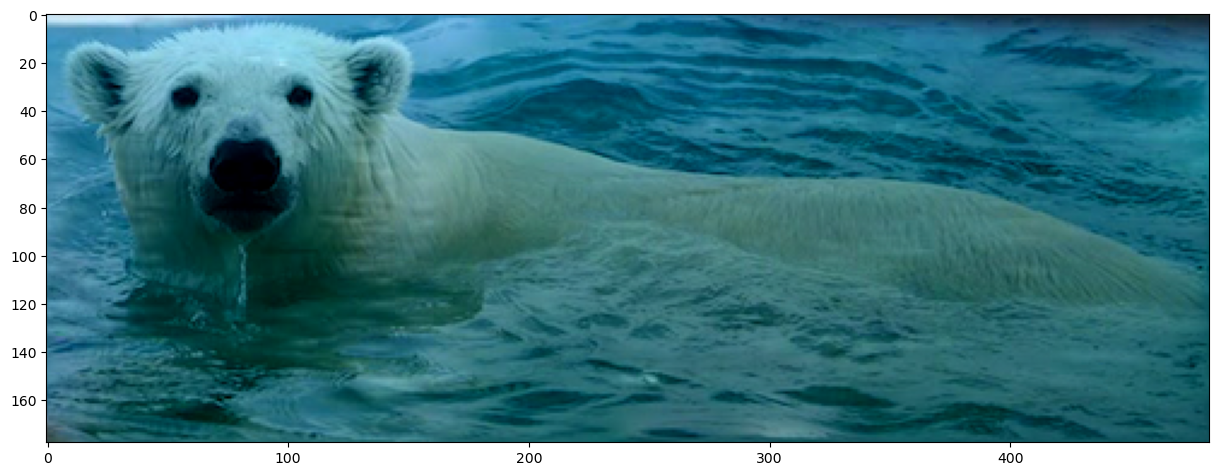

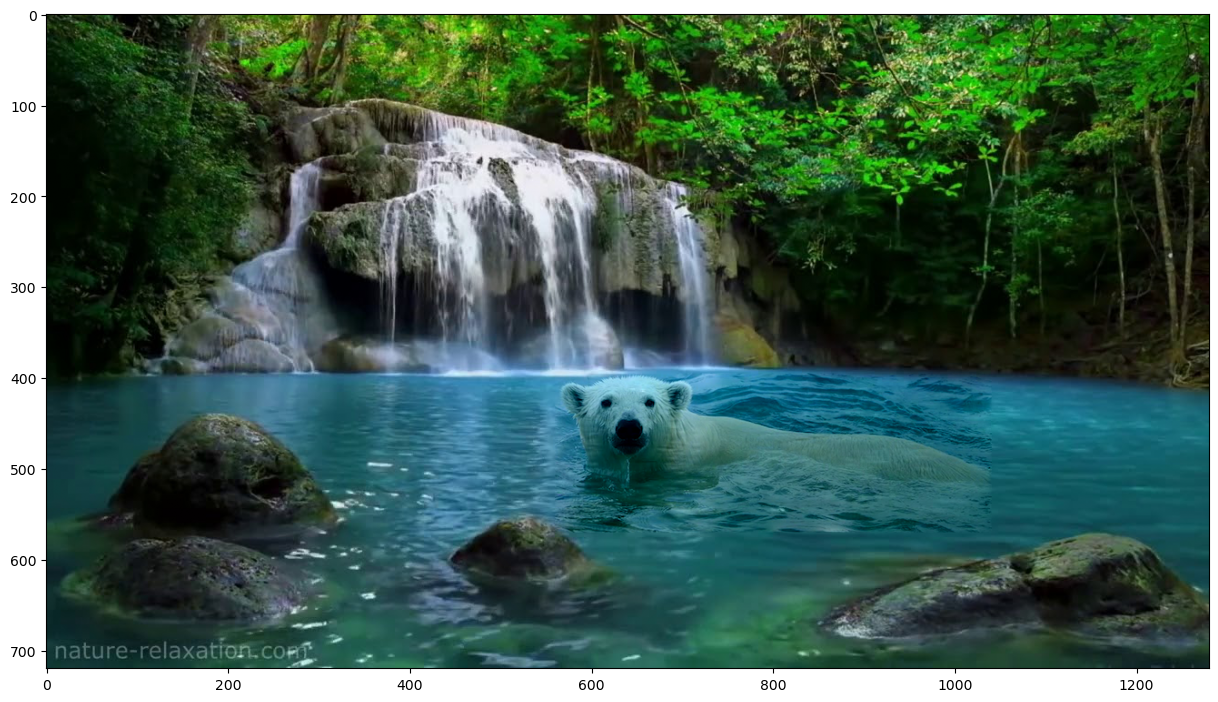

In [89]:
im_mix = np.zeros(object_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)


combined_img = utils.get_combined_img(background_img, im_mix, object_mask, bg_ul)
plt.figure(figsize=(15,15))
plt.imshow(combined_img)
plt.savefig('results/test3')


# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
  # feel free to change input parameters
    pass

## More gradient domain processing (up to 20 pts)